<h1 style="font-size:42px; text-align:center; margin-bottom:30px;">CO2 Concentration Prediction feat. ARIMA Model</h1>
<hr>
The goal of this project is to predict atmospheric CO2 concentration.    

ARIMA(<b>A</b>uto<b>R</b>egressive <b>I</b>ntegrated <b>M</b>oving <b>A</b>verage) is a model that can be fitted to time series data in order to better understand or predict future points in the series.

There are three distinct integers (p, d, q) that are used to parametrize ARIMA models. Because of that, ARIMA models are denoted with the notation ARIMA(p, d, q). Together these three parameters account for seasonality, trend, and noise in datasets:

* p is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.
* d is the integrated part of the model. This includes terms in the model that incorporate the amount of differencing (i.e. the number of past time points to subtract from the current value) to apply to the time series. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.
* q is the moving average part of the model. This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.

When dealing with seasonal effects, we make use of the seasonal ARIMA, which is denoted as ARIMA(p,d,q)(P,D,Q)s. Here, (p, d, q) are the non-seasonal parameters described above, while (P, D, Q) follow the same definition but are applied to the seasonal component of the time series. The term s is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.).

When working with time-series data in Python, should ensure that dates are used as an index.

In [79]:
# Import: necessary packages and modules
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [128]:
# Ticket: It seems that load_pandas() is not working on co2 dataset, switch to load() for now until the ticket is closed.
d = sm.datasets.co2.load().data
y = pd.DataFrame(data=d) 
y['date'] = y['date'].str.decode("utf-8")
y['date'] = pd.to_datetime(y['date'])
y = y.set_index('date')

In [129]:
# Fix: Missing value
y = y['co2'].resample('MS').mean()
y = y.fillna(y.bfill())

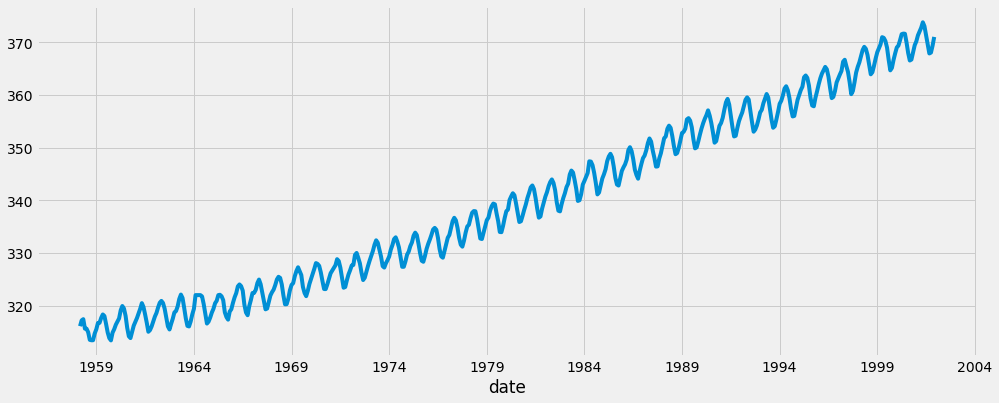

In [130]:
# Visualize: basic increasing trend
y.plot(figsize=(15, 6))
plt.show()

In [131]:
# Find: p, d and q using grid search
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [133]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:7612.583429881011
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6787.343624036737
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1854.828234141261
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1596.7111727641156
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1058.9388921320035
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1056.2878498284585
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1361.6578978072075
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1044.7647913337166
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:6881.048754098349
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:6072.662327360112
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1379.1941067312878
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1241.41747167922
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1084.8212083725516
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:780.4319753278725
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1119.5957893617642
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:807.0912988550679
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1675.8086923024293
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1240.2211199194078
A

In [134]:
# Fit: ARIMA model
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3182      0.092      3.446      0.001       0.137       0.499
ma.L1         -0.6257      0.076     -8.181      0.000      -0.776      -0.476
ar.S.L12       0.0010      0.001      1.732      0.083      -0.000       0.002
ma.S.L12      -0.8767      0.026    -33.787      0.000      -0.928      -0.826
sigma2         0.0971      0.004     22.636      0.000       0.089       0.106


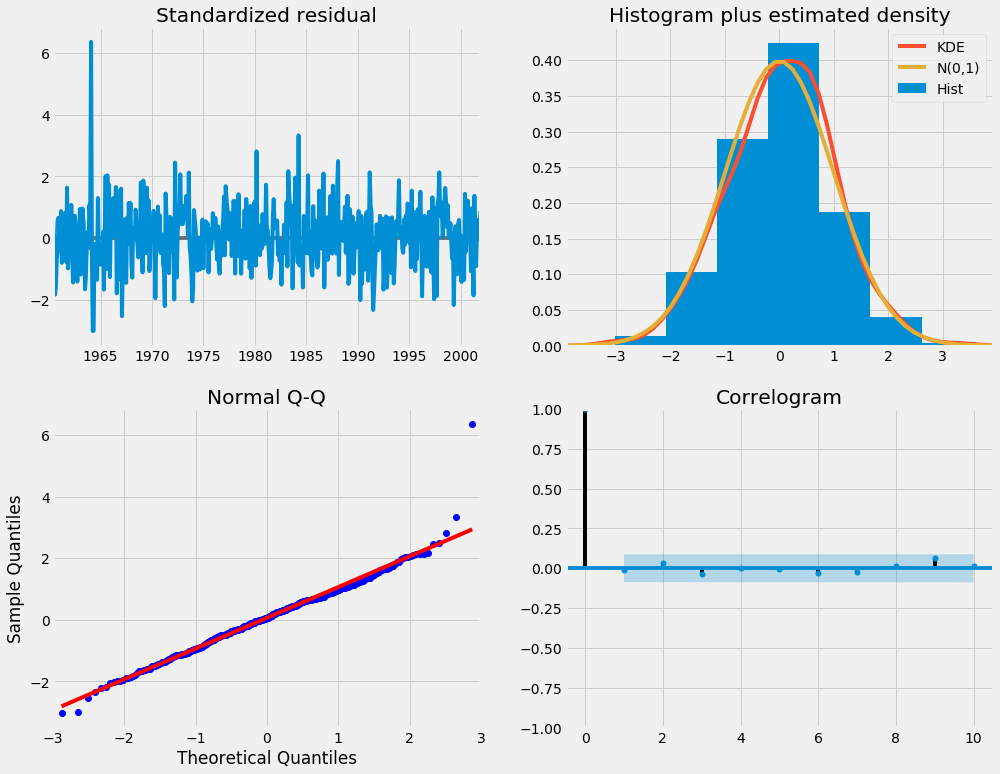

In [135]:
# Diagnostics: ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [136]:
# Predict: test data starting from 1998
pred = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)
pred_ci = pred.conf_int()

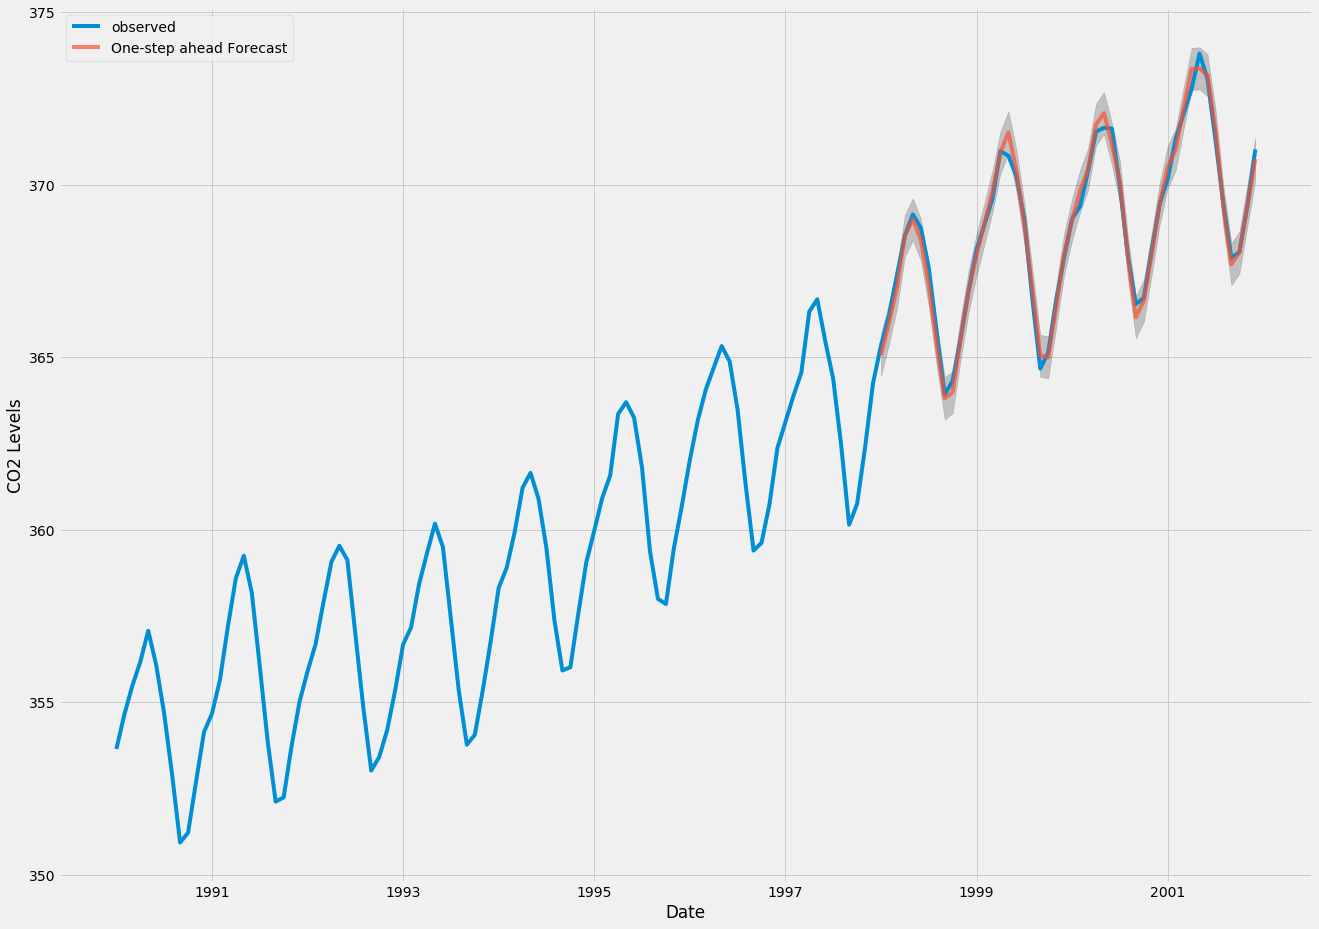

In [143]:
# Compare:
ax = y['1990':].plot(label='observed', figsize=(20, 15))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()

In [140]:
# Accuracy: compute the mean square error
y_forecasted = pred.predicted_mean
y_truth = y['1998-01-01':]

mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.07


In [141]:
# Predict: Dynamic
pred_dynamic = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

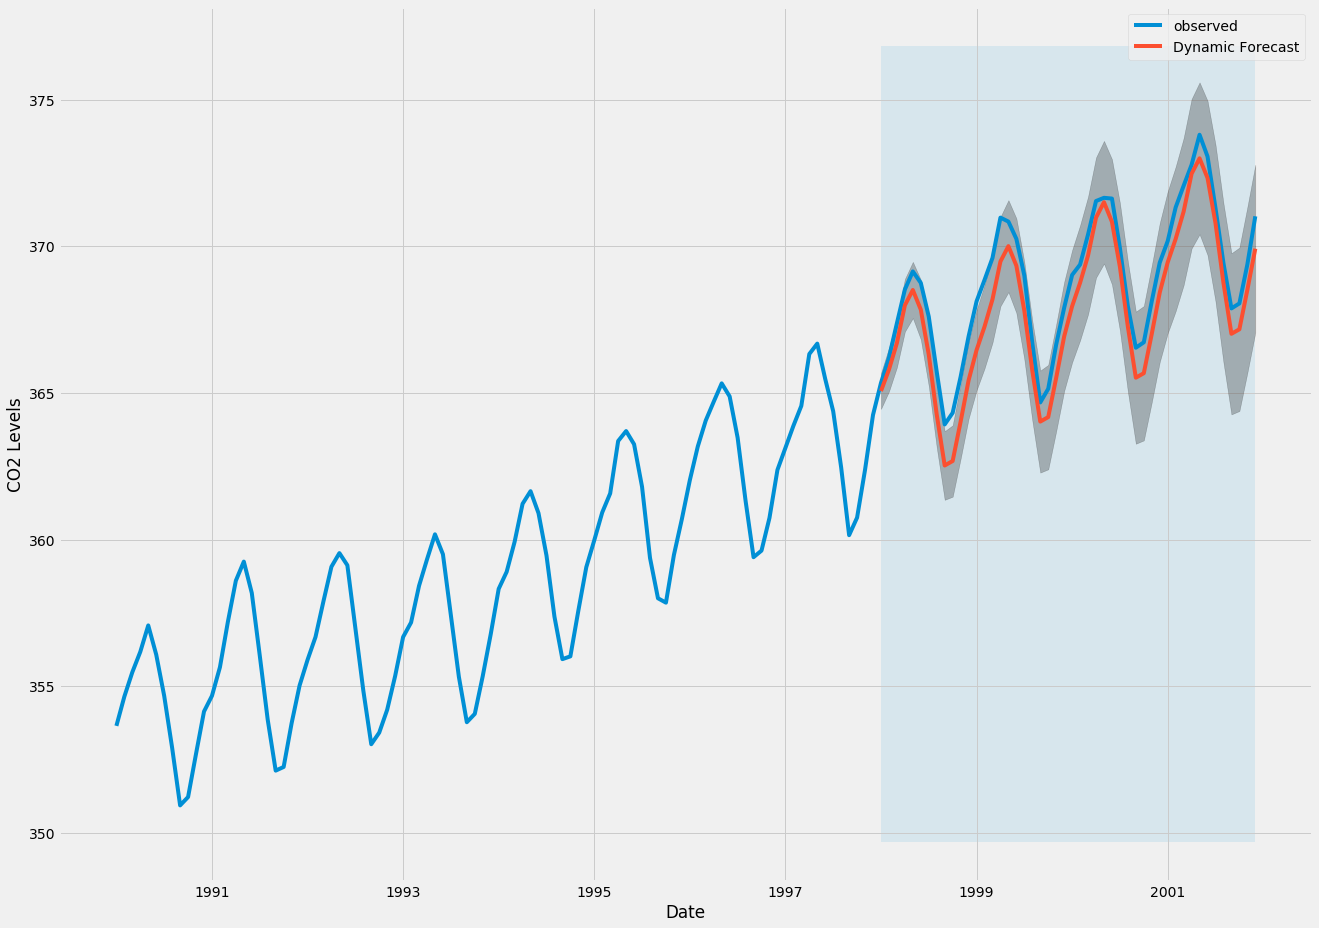

In [142]:
# Compare: Dynamic
ax = y['1990':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

In [144]:
# Accuracy: compute the mean square error
y_forecasted = pred_dynamic.predicted_mean
y_truth = y['1998-01-01':]

mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1.01


In [145]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=500)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

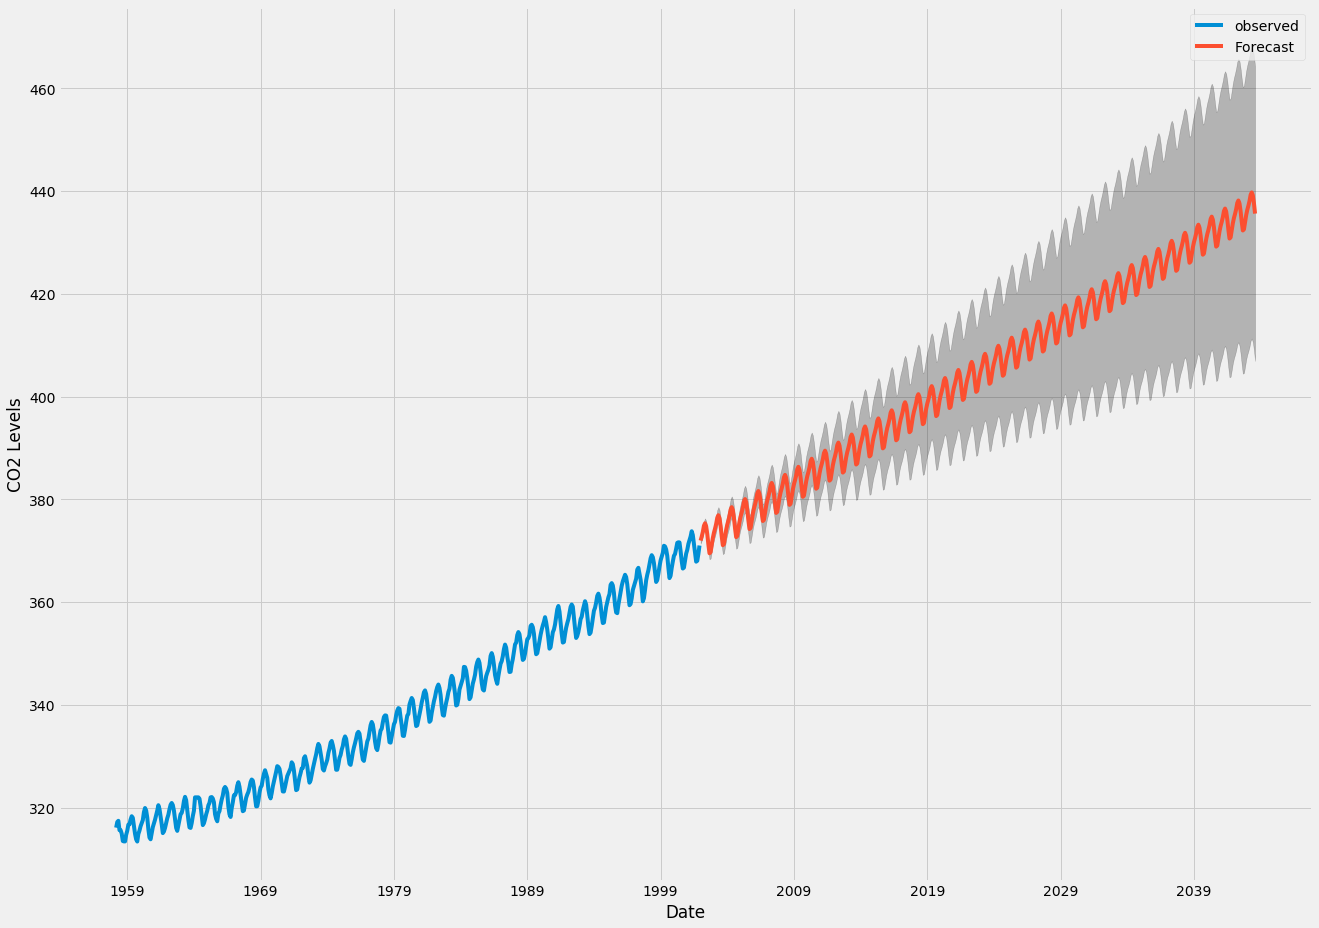

In [146]:
# Forecast: 
ax = y.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

#### Potential Enhancement
* Change the start date of your dynamic forecasts to see how this affects the overall quality of your forecasts.
* Try more combinations of parameters to see if you can improve the goodness-of-fit of your model.
* Select a different metric to select the best model. For example, we used the AIC measure to find the best model, but you could seek to optimize the out-of-sample mean square error instead.